<a href="https://colab.research.google.com/github/JennyMyy/Data-analytiikka/blob/main/Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Viinien luokittelu rypälelajikkeeen mukaan &ndash; osa 2

Lähde: https://archive.ics.uci.edu/dataset/109/wine


In [61]:
# Yhdistetään ensin Google driveen.

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/data


In [62]:
# Haetaan tarvittavat kirjastot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# jotta, saadaa jaettua data opetusdataa ja testidataan
from sklearn.model_selection import train_test_split

# mallit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Sekaannusmatriisin näyttämiseen
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [63]:
# Luetaan aineisto

df = pd.read_excel('wine.xlsx')
df

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


Kohdemuuttuja on **Y**, jonka arvot 1, 2 ja 3 ovat eri rypälelajikkeita.

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       178 non-null    int64  
 1   X1      178 non-null    float64
 2   X2      178 non-null    float64
 3   X3      178 non-null    float64
 4   X4      178 non-null    float64
 5   X5      178 non-null    int64  
 6   X6      178 non-null    float64
 7   X7      178 non-null    float64
 8   X8      178 non-null    float64
 9   X9      178 non-null    float64
 10  X10     178 non-null    float64
 11  X11     178 non-null    float64
 12  X12     178 non-null    float64
 13  X13     178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [65]:
# Kohdemuuttujan arvojen jakauma
df['Y'].value_counts()

Y
2    71
1    59
3    48
Name: count, dtype: int64

Arvot ovat sopivan tasaisesti jakautuneet.

<Axes: >

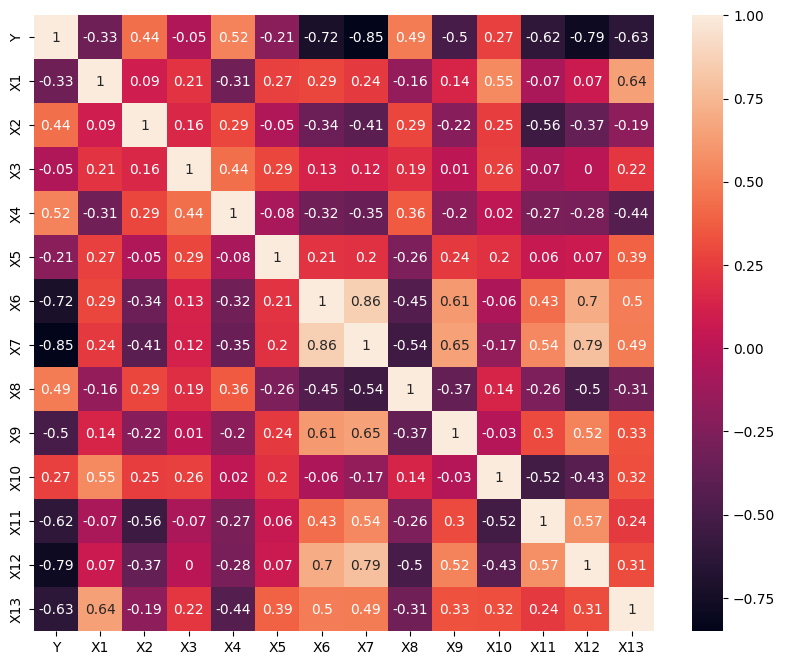

In [66]:
# Katsotaan korrelaatiokertoimet
plt.figure(figsize=(10,8))
sns.heatmap(df.corr().round(2), annot=True)

Eniten korreloivat X6, X7 ja X12.
> Katsotaan kuinka nämä erottelevat eri rypälelajikkeita.

<Axes: xlabel='Y', ylabel='X12'>

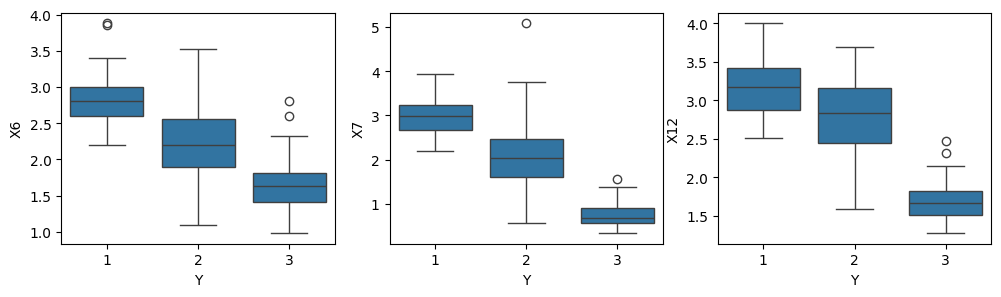

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

sns.boxplot(x='Y', y='X6', data=df, ax=axes[0])
sns.boxplot(x='Y', y='X7', data=df, ax=axes[1])
sns.boxplot(x='Y', y='X12', data=df, ax=axes[2])

* X6 ja X7 eniten eroavaisuuksia ja eniten rypälelajikkeelta eroavat 1 ja 3.
* X12 muuttujassa 1 ja 2 rypälelajikkeissa ei ole paljoa eroa kuin verrattuna 1 ja 3, jolloin on suurta eroavaisuutta.

Havaittavissa siis 1 ja 3 rypällelajikeen välillä eniten eroavaisuutta, kun 2 rypälelajike sijoittuu näiden välimaastoon.

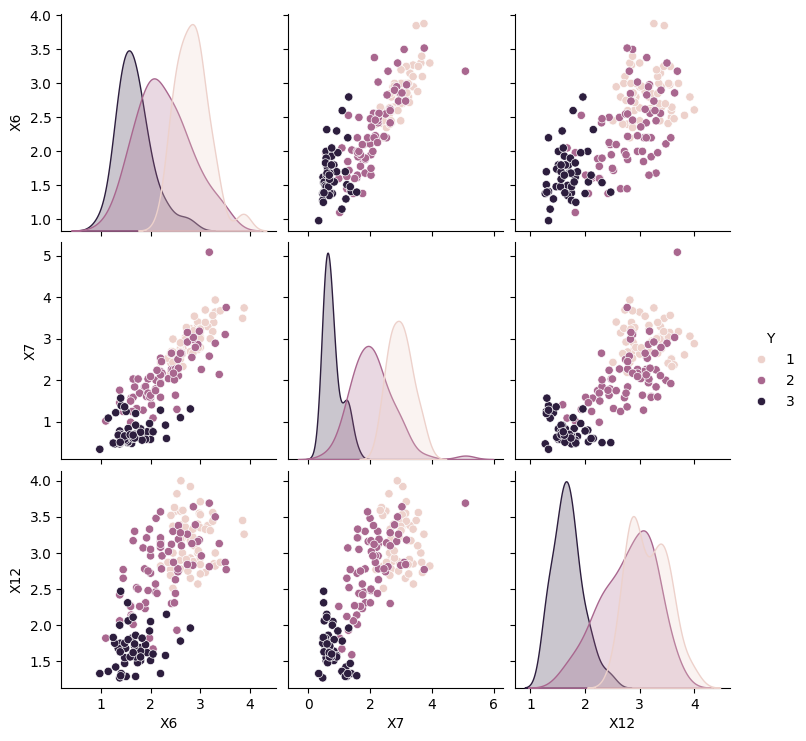

In [68]:
# Katsotaan erottelevuutta hajontakaaviolla

sns.pairplot(df[['X6', 'X7', 'X12', 'Y']], hue = 'Y')

Selkeää arottelevuutta ei ole, mutta rypälelajikkeiden 1 ja 3 välillä on.

# Mallin sovitus

In [69]:
# Selittävät muuttujat

X = df[['X6', 'X7', 'X12']]

# Kohdemuuttuja

y = df['Y']

# Datan jako opetus- ja testidataan

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [70]:
lrc = LogisticRegression(random_state=2)
lrc.fit(X_train, y_train)

dtc = DecisionTreeClassifier(max_depth=4, random_state=2)
dtc.fit(X_train, y_train)

rfc = RandomForestClassifier(max_depth=3, random_state=2)
rfc.fit(X_train, y_train)

gbc = GradientBoostingClassifier(max_depth=3, random_state=2)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=2)

# Mallin arviointi

In [71]:
print('Ennusteiden tarkkuus opetusdatassa:')
print(f'Logistinen regressio {lrc.score(X_train, y_train):.3f}')
print(f'Päätöspuu {dtc.score(X_train, y_train):.3f}')
print(f'Satunnaismetsä {rfc.score(X_train, y_train):.3f}')
print(f'Gradienttitehostus {gbc.score(X_train, y_train):.3f}')

Ennusteiden tarkkuus opetusdatassa:
Logistinen regressio 0.812
Päätöspuu 0.887
Satunnaismetsä 0.857
Gradienttitehostus 1.000


Ennusteet opetusdatassa näyttävät hyviltä ja Gradienttitehostus erinomaiselta.

In [72]:
print('Ennusteiden tarkkuus testidatassa:')
print(f'Logistinen regressio {lrc.score(X_test, y_test):.3f}')
print(f'Päätöspuu {dtc.score(X_test, y_test):.3f}')
print(f'Satunnaismetsä {rfc.score(X_test, y_test):.3f}')
print(f'Gradienttitehostus {gbc.score(X_test, y_test):.3f}')

Ennusteiden tarkkuus testidatassa:
Logistinen regressio 0.800
Päätöspuu 0.867
Satunnaismetsä 0.889
Gradienttitehostus 0.844


Ennusteet testidatassa ovat hyvin läellä opetusdataa. Ainoastaan gradienttitehostus on laskenut, mutta silti hyvä.

In [73]:
# Mallien laskemat ennusteet testidatalle (tarvitaan sekaannusmatriiseissa)
y_test_lrc = lrc.predict(X_test)
y_test_dtc = dtc.predict(X_test)
y_test_rfc = rfc.predict(X_test)
y_test_gbc = gbc.predict(X_test)

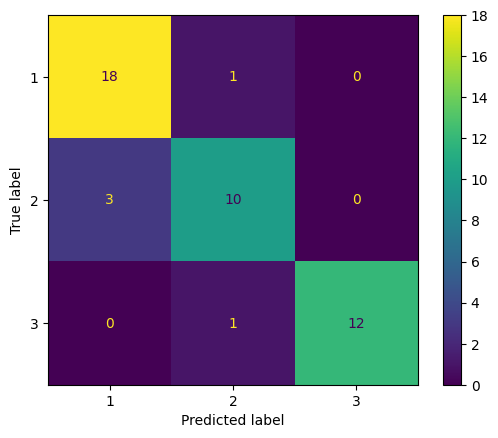

In [74]:
# Satunnaismetsän sekaannus-matriisi testidatalle
cm = confusion_matrix(y_test, y_test_rfc)

# Määritellään 'Y'-sarakkeen arvot, koska muuten arvot alkaisi nollasta.
display_labels = ['1', '2', '3']

# Piirretään confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()

Nähtävillä pieniä virheitä.

* Rypälelajike 1 ennustettiin 18/19 oikein.
* Rypälelajike 2 ennustettiin 10/13 oikein, mutta 3 ennustettiin olevan lajiketta 1.
* Rypälelajikkeet 1 ja 2 eivät ennustaneet ollenkaan lajiketta 3.
* Lajikkeen 3 meni oikein 12/13 ja ei ennustanut ollenkaan lajiketta 1.  

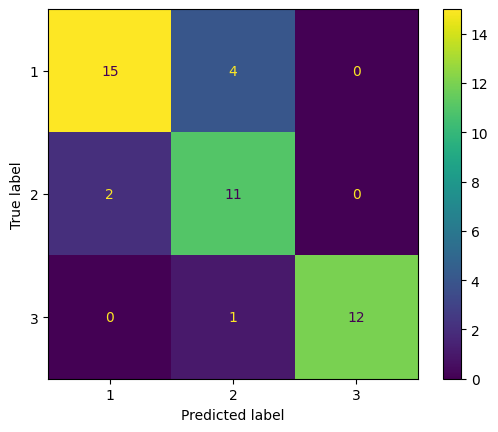

In [75]:
# Gradienttitehostuksen sekaannus-matriisi testidatalle
cm = confusion_matrix(y_test, y_test_gbc)

# Määritellään 'Y'-sarakkeen arvot
display_labels = ['1', '2', '3']

# Piirretään confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot()

Tässä nähtävillä myös vähän virheitä.

* Rypälelajike 1 ennustettiin 15/19 oikein. 4 ennustettiin lajiketta 2.
* Rypälelajike 2 ennustettiin 11/13 oikein, mutta 2 ennustettiin olevan lajiketta 1.
* Rypälelajikkeet 1 ja 2 eivät ennustaneet ollenkaan lajiketta 3.
* Lajikkeen 3 meni oikein 12/13 ja ei ennustanut ollenkaan lajiketta 1.

# Mallin käyttö ennustaminen

In [76]:
# Data kolmelle uudelle lajikkeelle (kekisitty itse).
Xnew = pd.DataFrame([[2.5, 3.8, 4.1], [3.8, 2.3, 1.5], [1.8, 2.4, 3.0]],
                    columns = ['X6', 'X7', 'X12'])
Xnew

,X6,X7,X12
0,2.5,3.8,4.1
1,3.8,2.3,1.5
2,1.8,2.4,3.0


In [77]:
# Sovelletaan seuraavassa gradienttitehostusta, sisältää myös todennäköisyydet
ennuste = gbc.predict(Xnew)
todnak = gbc.predict_proba(Xnew).round(2)
Xnew['ennuste'] = ennuste
Xnew[['Y 1', 'Y 2', 'Y 3']] = todnak
Xnew

,X6,X7,X12,ennuste,Y 1,Y 2,Y 3
0,2.5,3.8,4.1,1,0.99,0.01,0.00
1,3.8,2.3,1.5,3,0.00,0.42,0.58
2,1.8,2.4,3.0,1,0.96,0.04,0.00


Gradienttitehostus ennustaa ensimmäisen ja viimeisen lajikkeen olevan lajiketta 1 yli 90% todennäiköisyydellä. Toisen testitapauksen ennustaa olevan lajike 3 58% todennäköisyydellä, mutta lajike 2 todennäköisyys on myös 42%.